This notebook creates a random uniform sample of N points within the bounds of a shapefile and outputs files to load into CEO for labeling.

In [3]:
# Import libraries
from shapely.geometry import Point
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
# Specify the number of points
n = 10

The boundary can either be loaded from a private shapefile or the natural earth shapefile. Therefore, only one of the two below cells needs to be executed.

In [ ]:
# Load in custom shapefile
custom_shapefile = '/Users/hkerner/data/china/china_aoi_bounds/provinces/Provinces.shp'
boundary = gpd.read_file(custom_shapefile)
boundary.plot();

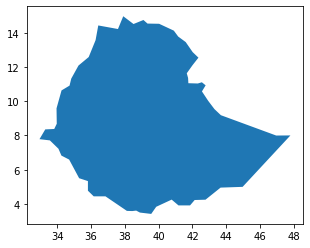

In [5]:
# Load in shapefile from natural earth
ne_shapefile = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
boundary = gpd.read_file(ne_shapefile)
boundary = boundary[boundary["SOVEREIGNT"] == "Ethiopia"]
boundary.plot();

In [6]:
# Specify the desired output file path
out_shp = '../data/random_sample_ceo_format.shp'

In [7]:
boundary

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
165,Admin-0 country,1,2,Ethiopia,ETH,0,2,Sovereign country,Ethiopia,ETH,...,None,None,None,None,None,None,None,None,None,"POLYGON ((47.78942 8.00300, 44.96360 5.00162, ..."


In [8]:
# Make sure the shapefile has EPSG:4326, otherwise convert it
print('Boundary shapefile CRS is %s' % boundary.crs)
if boundary.crs != 'epsg:4326':
    boundary = boundary.to_crs('epsg:4326')
    print('Boundary shapefile converted to %s' % boundary.crs)

Boundary shapefile CRS is epsg:4326


In [9]:
# Function for sampling random points. 
# From https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python
def random_points_in_polygon(num_points, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < num_points:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely points

In [10]:
# Sample n points within the shapefile
# Note: this assumes we want to sample N points within each shape/row in the shapefile/geodataframe
# Most shapefiles will likely only have one row if it is for a single region, but this allows us to
# stratify the samples by sub-regions if desired.
points = []
for i in range(boundary.shape[0]):
    points += random_points_in_polygon(n, boundary.iloc[i].geometry)

In [11]:
# Convert the list of points to a geodataframe
points_gdf = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(x=[p.x for p in points], 
                                                                  y=[p.y for p in points]))

<AxesSubplot:>

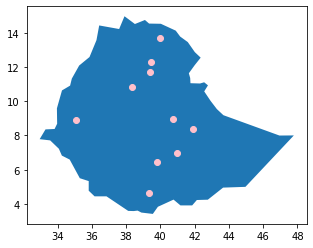

In [12]:
# Plot the random points
fig, ax = plt.subplots(1)
boundary.plot(ax=ax)
points_gdf.plot(ax=ax, color='pink')

In [13]:
# Add columns for CEO formatting
points_gdf['PLOTID'] = points_gdf.index
points_gdf['SAMPLEID'] = points_gdf.index

In [14]:
# Set the data type of the IDs to be integers
points_gdf['SAMPLEID'] = points_gdf['SAMPLEID'].astype(np.int64)
points_gdf['PLOTID'] = points_gdf['PLOTID'].astype(np.int64)

In [15]:
points_gdf

,geometry,PLOTID,SAMPLEID
0,POINT (41.92771 8.40684),0,0
1,POINT (39.33086 4.65141),1,1
2,POINT (39.46721 12.31591),2,2
3,POINT (38.36060 10.83449),3,3
4,POINT (40.71931 8.95098),4,4
5,POINT (39.80816 6.46415),5,5
6,POINT (39.95362 13.68884),6,6
7,POINT (39.36751 11.67843),7,7
8,POINT (35.07386 8.91298),8,8
9,POINT (40.98872 6.97552),9,9


In [16]:
points_gdf.crs = 'epsg:4326'

In [17]:
# Save the file as a new shapefile
points_gdf[['geometry', 'PLOTID', 'SAMPLEID']].to_file(out_shp, index=False)

# When creating the labeling project in CEO, use this file for 'Plot Design' and 'Sample Design' 
# (select SHP in the drop-down). You will need to zip the files before uploading.